In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pickle
import osmnx as ox
import csv
# Ensure output directory exists
output_dir = '../output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
def get_coordinates():
    while True:
        try:
            latitude = float(input("Enter the latitude (in decimal degrees): "))
            longitude = float(input("Enter the longitude (in decimal degrees): "))
            
            if 5.47 <= latitude <= 5.89 and -0.24 <= longitude <= -0.02:
                print(f"Coordinates ({latitude}, {longitude}) are valid for Accra.")
                return latitude, longitude
            else:
                print("Error: The coordinates are not within the valid range for Accra. Please try again.")
        except ValueError:
            print("Error: Please enter valid numeric values for latitude and longitude.")

# Get start and end coordinates
start_lat, start_lon = 5.608741666152156, -0.075866323410708
end_lat, end_lon = 5.643041503585579, -0.235185096524191
# start_lat, start_lon = get_coordinates()
# end_lat, end_lon = get_coordinates()


In [3]:
def segment_edge(line, segment_length=1):
    segments = []
    num_segments = int(line.length / segment_length)
    for i in range(num_segments):
        segment = LineString([line.interpolate(i / num_segments, normalized=True),
                              line.interpolate((i + 1) / num_segments, normalized=True)])
        segments.append(segment)
    return segments

def calculate_segment_weight(segment, roads_gdf, buildings_gdf, open_space_gdf, avoidance_zones_gdf):
    weight = segment.length  # Start with the base weight (length of the segment)

    if roads_gdf.intersects(segment).any():
        weight *= 1.5  # Increase weight if segment intersects a road
    if buildings_gdf.intersects(segment).any():
        weight *= 1  # Increase weight if segment intersects a building
    if open_space_gdf.intersects(segment).any():
        weight *= 0.8  # Decrease weight if segment intersects open space
    if avoidance_zones_gdf.intersects(segment).any():
        weight *= 3  # Heavily increase weight if segment intersects an avoidance zone

    return weight
def calculate_edge_weight(line, roads_gdf, buildings_gdf, open_space_gdf, avoidance_zones_gdf):
    segments = segment_edge(line)
    total_weight = sum(calculate_segment_weight(segment, roads_gdf, buildings_gdf, open_space_gdf, avoidance_zones_gdf) for segment in segments)
    return total_weight


In [4]:
def create_and_save_graph(health_facilities_gdf, roads_gdf, buildings_gdf, open_space_gdf, no_fly_zones_gdf, avoidance_zones_gdf, drone_range_km):
    G = nx.Graph()

    for idx1, row1 in health_facilities_gdf.iterrows():
        if not no_fly_zones_gdf.contains(row1.geometry).any():
            G.add_node(idx1, pos=(row1['longitude'], row1['latitude']))

            for idx2, row2 in health_facilities_gdf.iterrows():
                if idx1 != idx2:
                    distance = geodesic((row1['latitude'], row1['longitude']), (row2['latitude'], row2['longitude'])).km
                    
                    if distance <= drone_range_km:
                        line = LineString([row1.geometry, row2.geometry])

                        if no_fly_zones_gdf.intersects(line).any():
                            continue  # Skip if the line intersects a no-fly zone

                        edge_weight = calculate_edge_weight(line, roads_gdf, buildings_gdf, open_space_gdf, avoidance_zones_gdf)
                        G.add_edge(idx1, idx2, weight=edge_weight)

    with open(os.path.join(output_dir, 'advanced_route.pkl'), 'wb') as f:
        pickle.dump(G, f)
    print("Network graph created and saved as 'advanced_route.pkl'.")

def load_graph():
    with open(os.path.join(output_dir, 'advanced_route.pkl'), 'rb') as f:
        G = pickle.load(f)
    print("Network graph loaded from 'advanced_route.pkl'.")
    return G

def add_node_to_graph(G, lat, lon, node_name, health_facilities_gdf, roads_gdf, buildings_gdf, open_space_gdf, no_fly_zones_gdf, avoidance_zones_gdf, drone_range_km):
    point = Point(lon, lat)
    if no_fly_zones_gdf.contains(point).any():
        print(f"{node_name} is within a no-fly zone and cannot be added.")
        return None

    new_node_idx = max(G.nodes) + 1 if len(G.nodes) > 0 else 0
    G.add_node(new_node_idx, pos=(lon, lat), name=node_name)

    pos = nx.get_node_attributes(G, 'pos')
    pos[new_node_idx] = (lon, lat)
    nx.set_node_attributes(G, pos, 'pos')

    for idx, row in health_facilities_gdf.iterrows():
        distance = geodesic((lat, lon), (row['latitude'], row['longitude'])).km
        if distance <= drone_range_km:
            line = LineString([point, row.geometry])

            if no_fly_zones_gdf.intersects(line).any():
                print(f"Edge from {node_name} to {row['name']} intersects a no-fly zone, not adding.")
                continue  # Skip if the line intersects a no-fly zone

            edge_weight = calculate_edge_weight(line, roads_gdf, buildings_gdf, open_space_gdf, avoidance_zones_gdf)
            G.add_edge(new_node_idx, idx, weight=edge_weight)

    return new_node_idx




In [5]:
# Function to download land use data using OSMnx
def download_land_use_data(place_name="Accra, Ghana"):
    print("Downloading land use data...")

    # Download road network data
    roads = ox.graph_from_place(place_name, network_type='drive')
    roads_gdf = ox.graph_to_gdfs(roads, nodes=False, edges=True)

    # Download buildings data
    buildings_gdf = ox.geometries_from_place(place_name, tags={'building': True})

    # Download open spaces (parks, greenspaces)
    open_space_gdf = ox.geometries_from_place(place_name, tags={'leisure': 'park'})

    print("Land use data downloaded successfully.")
    return roads_gdf, buildings_gdf, open_space_gdf


In [6]:
# Load healthcare facilities
health_facilities_df = pd.read_csv('../data/accra_facilities_filtered.csv')
health_facilities_gdf = gpd.GeoDataFrame(
    health_facilities_df, 
    geometry=gpd.points_from_xy(health_facilities_df.longitude, health_facilities_df.latitude)
)

# Load no-fly zones and avoidance areas
no_fly_zones_gdf = gpd.read_file('../map/no_fly_zones.geojson')
avoidance_zones_gdf = gpd.read_file('../map/avoidance_zones.geojson')

# Download land use data using OSMnx
roads_gdf, buildings_gdf, open_space_gdf = download_land_use_data("Accra, Ghana")

/var/folders/g1/_5ywfh994dvfccvkj4cn_wy00000gp/T/ipykernel_98688/2535062007.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings_gdf = ox.geometries_from_place(place_name, tags={'building': True})


Land use data downloaded successfully.


/var/folders/g1/_5ywfh994dvfccvkj4cn_wy00000gp/T/ipykernel_98688/2535062007.py:13: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  open_space_gdf = ox.geometries_from_place(place_name, tags={'leisure': 'park'})


In [7]:

# Define drone constraints
drone_range_km = 7
payload_capacity_kg = 2

print(f"Drone constraints: Range = {drone_range_km} km, Payload Capacity = {payload_capacity_kg} kg")

Drone constraints: Range = 7 km, Payload Capacity = 2 kg


In [8]:

try:
    G = load_graph()
except FileNotFoundError:
    create_and_save_graph(health_facilities_gdf, roads_gdf, buildings_gdf, open_space_gdf, no_fly_zones_gdf, avoidance_zones_gdf, drone_range_km)
    G = load_graph()

start_node = add_node_to_graph(G, start_lat, start_lon, 'Start', health_facilities_gdf, roads_gdf, buildings_gdf, open_space_gdf, no_fly_zones_gdf, avoidance_zones_gdf, drone_range_km)
end_node = add_node_to_graph(G, end_lat, end_lon, 'End', health_facilities_gdf, roads_gdf, buildings_gdf, open_space_gdf, no_fly_zones_gdf, avoidance_zones_gdf, drone_range_km)


Network graph loaded from 'advanced_route.pkl'.
Edge from End to Jinlet Pharmacy intersects a no-fly zone, not adding.
Edge from End to Ernest Chemists intersects a no-fly zone, not adding.
Edge from End to Airport Womens Hospital intersects a no-fly zone, not adding.


/Users/tg1523/anaconda3/envs/drone_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Shortest path found: [297, 34, 236, 118, 86, 298]


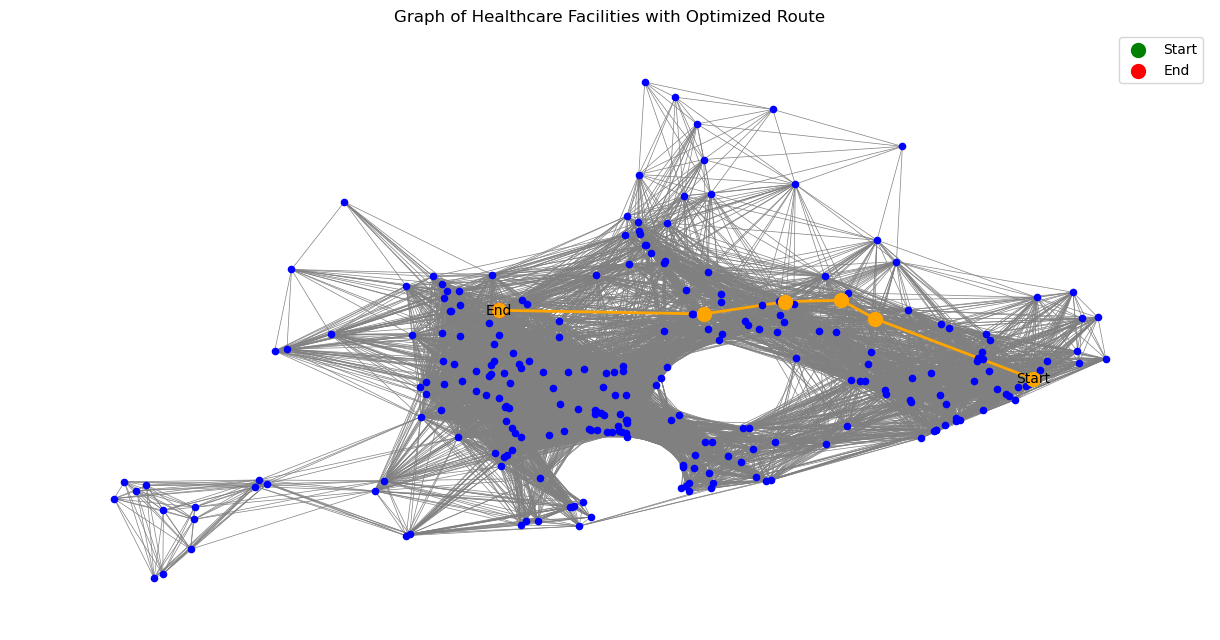

Route data saved to ../output/advanced_drone_route.csv


In [9]:
if start_node is not None and end_node is not None:
    try:
        shortest_path = nx.dijkstra_path(G, start_node, end_node, weight='weight')
        print("Shortest path found:", shortest_path)
        
        pos = nx.get_node_attributes(G, 'pos')

        missing_pos_nodes = [node for node in G.nodes if node not in pos]
        if missing_pos_nodes:
            print(f"Warning: Nodes without positions detected: {missing_pos_nodes}")
            G.remove_nodes_from(missing_pos_nodes)
            print(f"Removed nodes without positions: {missing_pos_nodes}")
        
        # Visualization of the graph and the optimized route
        plt.figure(figsize=(12, 6))
        facility_nodes = [node for node in G.nodes if node in pos]

        nx.draw(G, pos, nodelist=facility_nodes, node_size=20, node_color="blue", edge_color="gray", width=0.5, font_size=8)
        nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color="green", node_size=100, label="Start")
        nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color="red", node_size=100, label="End")
        nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color="orange", node_size=100)
        nx.draw_networkx_edges(G, pos, edgelist=list(zip(shortest_path[:-1], shortest_path[1:])), edge_color="orange", width=2)
        nx.draw_networkx_labels(G, pos, labels={start_node: 'Start', end_node: 'End'}, font_size=10, font_color="black")

        plt.title("Graph of Healthcare Facilities with Optimized Route")
        plt.legend()
        plt.show()

        # Save the route data to a CSV file
        route_data = []

        # Add start node
        start_pos = pos[start_node]
        route_data.append({
            "label": "Start",
            "lat": start_pos[1],
            "longitude": start_pos[0]
        })

        # Add intermediate nodes (charging stations)
        for node in shortest_path[1:-1]:
            node_pos = pos[node]
            route_data.append({
                "label": f"Charging Station {node}",
                "lat": node_pos[1],
                "longitude": node_pos[0]
            })

        # Add end node
        end_pos = pos[end_node]
        route_data.append({
            "label": "End",
            "lat": end_pos[1],
            "longitude": end_pos[0]
        })

        # Define the CSV file path
        csv_file_path = '../output/advanced_drone_route.csv'

        # Write the data to a CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=["label", "lat", "longitude"])
            writer.writeheader()
            writer.writerows(route_data)

        print(f"Route data saved to {csv_file_path}")
    
    except nx.NetworkXNoPath:
        print("Error: No path found between the start and end nodes.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print("Error: Start or end node was not added due to being within a no-fly zone.")

In [10]:
import folium
from folium.plugins import MarkerCluster

In [11]:
# Interactive Map Visualization with Folium
m = folium.Map(location=[5.55, -0.2], zoom_start=12)

# Add healthcare facilities as markers
marker_cluster = MarkerCluster().add_to(m)
for idx, row in health_facilities_gdf.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name']).add_to(marker_cluster)

# Add no-fly zones as circles
for _, row in no_fly_zones_gdf.iterrows():
    folium.Circle(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=2000,  # Adjust radius accordingly
        color='red',
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

# Add avoidance zones as circles
for _, row in avoidance_zones_gdf.iterrows():
    folium.Circle(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=100,  # Adjust radius accordingly
        color='blue',
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

# If a path has been found, plot it
if 'shortest_path' in locals():
    path_coordinates = [(pos[node][1], pos[node][0]) for node in shortest_path]
    folium.PolyLine(path_coordinates, color="purple", weight=2.5, opacity=1).add_to(m)

# Display the interactive map
m